In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
from scipy import stats
import pingouin as pg
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from patsy import dmatrix
import seaborn as sns
from statsmodels.stats.multivariate import test_cov_oneway
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv('data/all_weights.csv')
df.columns

Index(['Effort', 'Helpfulness', 'Trustworthy', 'Anger', 'Online', 'Empathy',
       'Familiarity', 'group', 'EmpathyBot', 'AngerInducement', 'WithAnger',
       'Q1.2', 'Q1.3', 'Q1.4', 'Q2.1', 'Q2.2', 'Q2.3', 'Q1_2', 'Q1_3', 'Q1_4',
       'Q2_1', 'Q2_2', 'Q2_3', 'ComprehensionCount'],
      dtype='object')

In [3]:
dvs = ['Effort', 'Helpfulness', 'Trustworthy']
between = 'EmpathyBot'
covar = 'WithAnger'
control = 'ComprehensionCount'


In [4]:
# Contrast Coding asked by Reviewer 2
df[covar] = df[covar].map({'No': -0.5, 'Yes': 0.5})
df[between] = df[between].map({'Empathy': 0.5, 'NonEmpathy': 0, 'FAQ': -0.5})

In [5]:
# 1. Multivariate Normality Test
mv_normality = pg.multivariate_normality(df[dvs])
print("Multivariate Normality Test:")
print(mv_normality)

Multivariate Normality Test:
HZResults(hz=7.08027939415229, pval=7.193483373993474e-37, normal=False)


In [6]:
# 2. Univariate Normality Tests
print("\nUnivariate Normality Tests:")
for dv in dvs:
    _, p = stats.normaltest(df[dv])
    print(f"{dv}: p-value = {p:.4f}")


Univariate Normality Tests:
Effort: p-value = 0.0000
Helpfulness: p-value = 0.0000
Trustworthy: p-value = 0.0000


In [7]:
# 3. Homogeneity of Variance-Covariance Matrices (Box's M Test)
groups = df[between].unique()
cov_list = [df[df[between] == group][dvs].cov().values for group in groups]
nobs_list = [df[df[between] == group].shape[0] for group in groups]

box_test = test_cov_oneway(cov_list, nobs_list)
print("\nBox's M Test for Homogeneity of Variance-Covariance Matrices:")
print(f"statistic = {box_test.statistic:.4f}, p-value = {box_test.pvalue:.4f}")


Box's M Test for Homogeneity of Variance-Covariance Matrices:
statistic = 2.4898, p-value = 0.0029


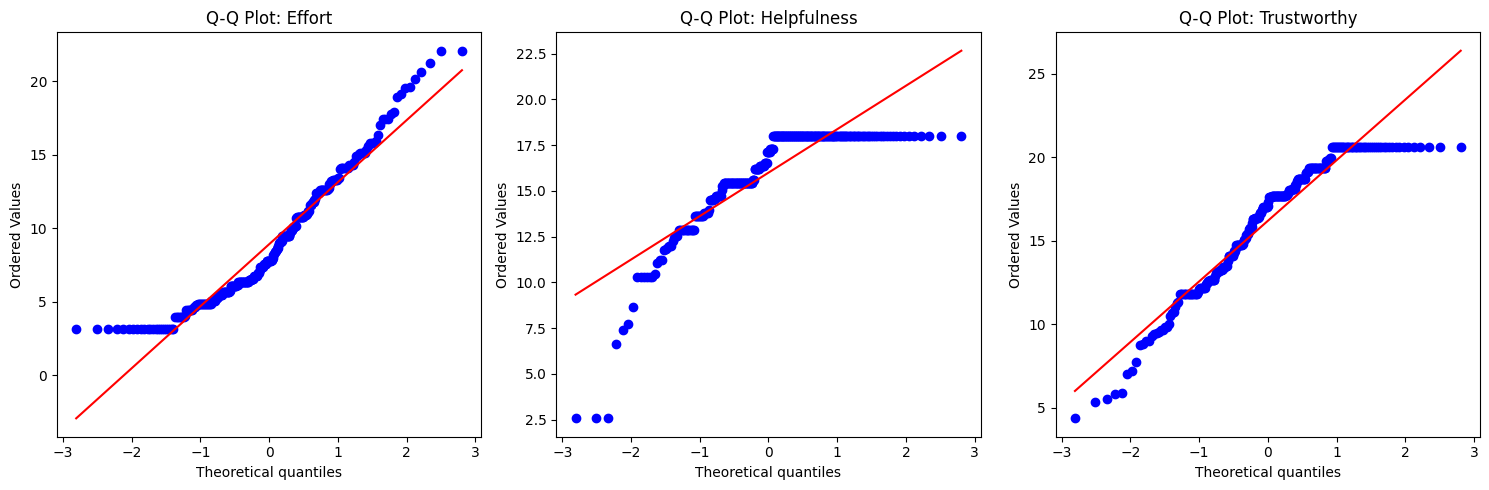

In [8]:
# 4. Visual inspection: Q-Q plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, dv in enumerate(dvs):
    stats.probplot(df[dv], dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q Plot: {dv}")
plt.tight_layout()
plt.show()

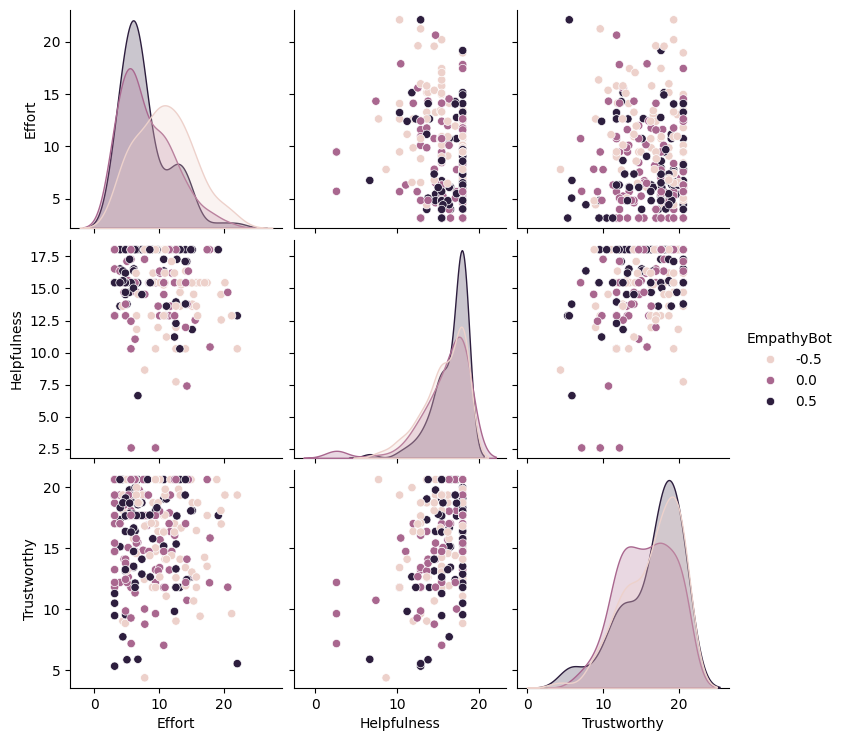

In [9]:
# 5. Visual inspection: Scatter plots
sns.pairplot(df[dvs + [between]], hue=between)
plt.show()

In [10]:
def add_significance(val, p):
    val_str = f"{val:.2f}"
    if p < 0.001:
        return val_str + "***"
    elif p < 0.01:
        return val_str + "**"
    elif p < 0.05:
        return val_str + "*"
    else:
        return val_str


In [11]:
# 6. Correlation matrix
# DVs are ordered variables - Spearman's correlation coefficient
# Does not assume normality of the data
## Weak correlation: 0.1 to 0.3
## Moderate correlation: 0.3 to 0.5
## Strong correlation: > 0.5
correlation_matrix = df[dvs].corr(method='spearman')
p_values = df[dvs].corr(method=lambda x, y: stats.spearmanr(x, y)[1])

correlation_matrix_with_sig = correlation_matrix.copy()
for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        val = correlation_matrix.loc[idx, col]
        p = p_values.loc[idx, col]
        correlation_matrix_with_sig.loc[idx, col] = add_significance(val, p)

print("\nCorrelation Matrix with Significance Levels:")
print(correlation_matrix_with_sig)
print("\nSignificance levels: * p<0.05, ** p<0.01, *** p<0.001")


Correlation Matrix with Significance Levels:
               Effort Helpfulness Trustworthy
Effort           1.00    -0.27***       -0.05
Helpfulness  -0.27***        1.00     0.42***
Trustworthy     -0.05     0.42***        1.00

Significance levels: * p<0.05, ** p<0.01, *** p<0.001


C:\Users\11046\AppData\Local\Temp\ipykernel_42060\848994235.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correlation_matrix_with_sig.loc[idx, col] = add_significance(val, p)
C:\Users\11046\AppData\Local\Temp\ipykernel_42060\848994235.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.27***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correlation_matrix_with_sig.loc[idx, col] = add_significance(val, p)
C:\Users\11046\AppData\Local\Temp\ipykernel_42060\848994235.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.05' has dtype incompatible with float64, please explicitly cast to a comp

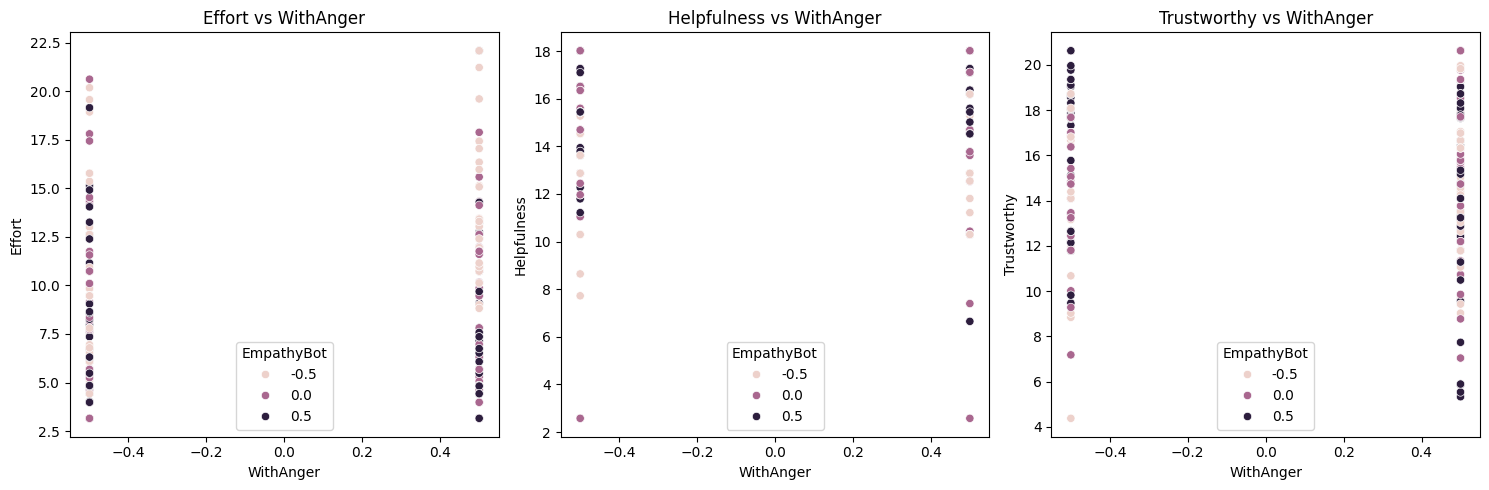

In [12]:
# 7. Linearity assumption
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, dv in enumerate(dvs):
    sns.scatterplot(data=df, x=covar, y=dv, hue=between, ax=axes[i])
    axes[i].set_title(f"{dv} vs {covar}")
plt.tight_layout()
plt.show()

In [13]:
# 8. Homogeneity of regression slopes
print("\nHomogeneity of Regression Slopes:")
for dv in dvs:
    model = pg.ancova(data=df, dv=dv, between=between, covar=covar, effsize="n2")
    print(f"\n{dv}:")
    print(model)


Homogeneity of Regression Slopes:

Effort:
       Source           SS   DF          F         p-unc        n2
0  EmpathyBot   547.779849    2  16.191191  2.264635e-07  0.106032
1   WithAnger     0.346777    1   0.020500  8.862552e-01  0.000067
2    Residual  4618.063547  273        NaN           NaN       NaN

Helpfulness:
       Source           SS   DF         F     p-unc        n2
0  EmpathyBot    45.374486    2  3.081282  0.047500  0.022067
1   WithAnger     0.722336    1  0.098105  0.754355  0.000351
2    Residual  2010.078285  273       NaN       NaN       NaN

Trustworthy:
       Source           SS   DF         F     p-unc        n2
0  EmpathyBot    43.480691    2  1.560967  0.211801  0.011235
1   WithAnger    24.518498    1  1.760440  0.185678  0.006335
2    Residual  3802.203374  273       NaN       NaN       NaN


In [14]:
# Function to apply transformations
def apply_transformation(data, transform):
    if transform == 'log':
        return np.log(data - data.min() + 1)
    elif transform == 'sqrt':
        return np.sqrt(data - data.min())
    elif transform == 'reciprocal':
        return 1 / (data - data.min() + 1)
    elif transform == 'boxcox':
        return stats.boxcox(data - data.min() + 1)[0]

In [15]:
# List of transformations to try
transformations = ['log', 'sqrt', 'reciprocal', 'boxcox']

# Try different transformations
for transform in transformations:
    print(f"\nTrying {transform} transformation:")
    df_transformed = df.copy()
    
    for dv in dvs:
        df_transformed[dv] = apply_transformation(df[dv], transform)
    
    # Multivariate Normality Test
    mv_normality = pg.multivariate_normality(df_transformed[dvs])
    print("Multivariate Normality Test:")
    print(mv_normality)
    
    # Univariate Normality Tests
    print("\nUnivariate Normality Tests:")
    for dv in dvs:
        _, p = stats.normaltest(df_transformed[dv])
        print(f"{dv}: p-value = {p:.4f}")
    
    # Box's M Test
    groups = df_transformed[between].unique()
    cov_list = [df_transformed[df_transformed[between] == group][dvs].cov().values for group in groups]
    nobs_list = [df_transformed[df_transformed[between] == group].shape[0] for group in groups]
    box_test = test_cov_oneway(cov_list, nobs_list)
    print("\nBox's M Test for Homogeneity of Variance-Covariance Matrices:")
    print(f"statistic = {box_test.statistic:.4f}, p-value = {box_test.pvalue:.4f}")


Trying log transformation:
Multivariate Normality Test:
HZResults(hz=13.911675313554321, pval=1.6092760285704027e-61, normal=False)

Univariate Normality Tests:
Effort: p-value = 0.0004
Helpfulness: p-value = 0.0000
Trustworthy: p-value = 0.0000

Box's M Test for Homogeneity of Variance-Covariance Matrices:
statistic = 14.0816, p-value = 0.0000

Trying sqrt transformation:
Multivariate Normality Test:
HZResults(hz=9.129671289862095, pval=2.1963024772036678e-45, normal=False)

Univariate Normality Tests:
Effort: p-value = 0.0548
Helpfulness: p-value = 0.0000
Trustworthy: p-value = 0.0000

Box's M Test for Homogeneity of Variance-Covariance Matrices:
statistic = 8.6153, p-value = 0.0000

Trying reciprocal transformation:
Multivariate Normality Test:
HZResults(hz=74.36599157830526, pval=7.958883805781995e-151, normal=False)

Univariate Normality Tests:
Effort: p-value = 0.0000
Helpfulness: p-value = 0.0000
Trustworthy: p-value = 0.0000

Box's M Test for Homogeneity of Variance-Covariance

In [16]:
# Apply Box-Cox transformation
df_boxcox = df.copy()
for dv in dvs:
    df_boxcox[dv], _ = stats.boxcox(df[dv] - df[dv].min() + 1)

In [17]:
# Perform MANCOVA with transformed data
formula = f"{'+'.join(dvs)} ~ C({between}) + {covar} + C({between}):{covar}"
manova = MANOVA.from_formula(formula, data=df_boxcox)
print("MANCOVA Results:")
print(manova.mv_test())

MANCOVA Results:
                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.1543 3.0000 269.0000 491.2947 0.0000
         Pillai's trace 0.8457 3.0000 269.0000 491.2947 0.0000
 Hotelling-Lawley trace 5.4791 3.0000 269.0000 491.2947 0.0000
    Roy's greatest root 5.4791 3.0000 269.0000 491.2947 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
      C(EmpathyBot)      Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.8707 6.0000 538.0000  6.4270 0.0000
          Pillai's trace 0.1311 6.0000 540.0000  6.3152 0

In [18]:
# Univariate ANCOVAs without interaction term
print("\nUnivariate ANCOVA Results (without interaction):")
for dv in dvs:
    formula = f"{dv} ~ C({between}) + {covar}"
    model = ols(formula, data=df_boxcox).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nANCOVA for {dv}:")
    print(anova_table)

    # Calculate and print partial eta-squared
    total_ss = anova_table['sum_sq'].sum()
    for predictor in anova_table.index:
        if predictor != 'Residual':
            partial_eta_sq = anova_table.loc[predictor, 'sum_sq'] / (anova_table.loc[predictor, 'sum_sq'] + anova_table.loc['Residual', 'sum_sq'])
            print(f"Partial eta-squared for {predictor}: {partial_eta_sq:.4f}")

    # Post-hoc for significant main effects
    if anova_table.loc['C(EmpathyBot)', 'PR(>F)'] < 0.05:
        print(f"\nTukey's HSD for {dv} (EmpathyBot):")
        tukey = pairwise_tukeyhsd(df_boxcox[dv], df[between])
        print(tukey)


Univariate ANCOVA Results (without interaction):

ANCOVA for Effort:
                   sum_sq     df          F        PR(>F)
C(EmpathyBot)   49.425636    2.0  15.775715  3.284910e-07
WithAnger        0.049169    1.0   0.031388  8.595094e-01
Residual       427.657277  273.0        NaN           NaN
Partial eta-squared for C(EmpathyBot): 0.1036
Partial eta-squared for WithAnger: 0.0001

Tukey's HSD for Effort (EmpathyBot):
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  -0.5    0.0  -0.8715    0.0 -1.3068 -0.4362   True
  -0.5    0.5  -0.9194    0.0 -1.3512 -0.4877   True
   0.0    0.5   -0.048 0.9632 -0.4809   0.385  False
----------------------------------------------------

ANCOVA for Helpfulness:
                     sum_sq     df         F    PR(>F)
C(EmpathyBot)  1.693863e+07    2.0  3.143736  0.044687
WithAnger      7.712267e+05    1.0  0.286273  0.593055
Residual   

In [19]:
# Univariate ANCOVAs with interaction term
print("\nUnivariate ANCOVA Results (with interaction):")
for dv in dvs:
    formula = f"{dv} ~ C({between}) + {covar} + C({between}):{covar}"
    model = ols(formula, data=df_boxcox).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nANCOVA for {dv}:")
    print(anova_table)

    # Calculate and print partial eta-squared
    total_ss = anova_table['sum_sq'].sum()
    for predictor in anova_table.index:
        if predictor != 'Residual':
            partial_eta_sq = anova_table.loc[predictor, 'sum_sq'] / (anova_table.loc[predictor, 'sum_sq'] + anova_table.loc['Residual', 'sum_sq'])
            print(f"Partial eta-squared for {predictor}: {partial_eta_sq:.4f}")

    # Post-hoc for significant main effects
    if anova_table.loc['C(EmpathyBot)', 'PR(>F)'] < 0.05:
        print(f"\nTukey's HSD for {dv} (EmpathyBot):")
        tukey = pairwise_tukeyhsd(df_boxcox[dv], df[between])
        print(tukey)

    # Simple effects analysis if interaction is significant
    if anova_table.loc[f'C({between}):{covar}', 'PR(>F)'] < 0.05:
        print(f"\nSimple effects analysis for {dv}:")
        for anger_level in df_boxcox[covar].unique():
            subset = df_boxcox[df_boxcox[covar] == anger_level]
            simple_effect = pg.anova(data=subset, dv=dv, between=between, detailed=True)
            print(f"\nSimple effect of {between} when {covar} = {anger_level}:")
            print(simple_effect)


Univariate ANCOVA Results (with interaction):

ANCOVA for Effort:
                             sum_sq     df          F        PR(>F)
C(EmpathyBot)             49.425636    2.0  15.731558  3.437364e-07
WithAnger                  0.049169    1.0   0.031300  8.597051e-01
C(EmpathyBot):WithAnger    1.941431    2.0   0.617933  5.398152e-01
Residual                 425.715846  271.0        NaN           NaN
Partial eta-squared for C(EmpathyBot): 0.1040
Partial eta-squared for WithAnger: 0.0001
Partial eta-squared for C(EmpathyBot):WithAnger: 0.0045

Tukey's HSD for Effort (EmpathyBot):
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  -0.5    0.0  -0.8715    0.0 -1.3068 -0.4362   True
  -0.5    0.5  -0.9194    0.0 -1.3512 -0.4877   True
   0.0    0.5   -0.048 0.9632 -0.4809   0.385  False
----------------------------------------------------

ANCOVA for Helpfulness:
               

In [20]:
# Perform non-parametric tests
print("\nNon-parametric Kruskal-Wallis tests:")
for dv in dvs:
    kruskal = pg.kruskal(data=df_boxcox, dv=dv, between=between)
    print(f"\nKruskal-Wallis test for {dv}:")
    print(kruskal)


Non-parametric Kruskal-Wallis tests:

Kruskal-Wallis test for Effort:
             Source  ddof1         H         p-unc
Kruskal  EmpathyBot      2  29.38687  4.156448e-07

Kruskal-Wallis test for Helpfulness:
             Source  ddof1         H     p-unc
Kruskal  EmpathyBot      2  5.789361  0.055317

Kruskal-Wallis test for Trustworthy:
             Source  ddof1         H     p-unc
Kruskal  EmpathyBot      2  4.203579  0.122238


In [21]:
# Regression analyses for the three DVs
for dv in dvs:
    # Model 1: Control only
    formula_control = f"{dv} ~ {control}"
    model_control = sm.OLS.from_formula(formula_control, data=df_boxcox).fit()
    print(f"\nRegression results for {dv} (Control only):")
    print(model_control.summary())

    # Model 2: Control + Main effects
    formula_main = f"{dv} ~ {control} + C({between}) + {covar}"
    model_main = sm.OLS.from_formula(formula_main, data=df_boxcox).fit()
    print(f"\nRegression results for {dv} (Main effects):")
    print(model_main.summary())

    # Model 3: Control + Main effects + Interaction
    formula_interaction = f"{dv} ~ {control} + C({between}) + {covar} + C({between}):{covar}"
    model_interaction = sm.OLS.from_formula(formula_interaction, data=df_boxcox).fit()
    print(f"\nRegression results for {dv} (With interaction):")
    print(model_interaction.summary())


Regression results for Effort (Control only):
                            OLS Regression Results                            
Dep. Variable:                 Effort   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.105
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.148
Time:                        21:33:24   Log-Likelihood:                -467.30
No. Observations:                 277   AIC:                             938.6
Df Residuals:                     275   BIC:                             945.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [24]:
for dv in dvs:
    # Model 1: Control only (unchanged)
    formula_control = f"{dv} ~ {control}"
    model_control = sm.OLS.from_formula(formula_control, data=df_boxcox).fit()
    print(f"\nRegression results for {dv} (Control only):")
    print(model_control.summary())
    
    # Model 2: Main effects with numeric coding
    formula_main = f"{dv} ~ {control} + {between} + {covar}"  # or 'empathizing'
    model_main = sm.OLS.from_formula(formula_main, data=df_boxcox).fit()
    print(f"\nRegression results for {dv} (Main effects):")
    print(model_main.summary())
    
    # Model 3: Interaction with numeric coding
    formula_interaction = f"{dv} ~ {control} + {between} + {covar} + {between}:{covar}"
    model_interaction = sm.OLS.from_formula(formula_interaction, data=df_boxcox).fit()
    print(f"\nRegression results for {dv} (With interaction):")
    print(model_interaction.summary())


Regression results for Effort (Control only):
                            OLS Regression Results                            
Dep. Variable:                 Effort   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.105
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.148
Time:                        22:00:57   Log-Likelihood:                -467.30
No. Observations:                 277   AIC:                             938.6
Df Residuals:                     275   BIC:                             945.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [21]:
## FAQ vs NonEmpathy 
# Filter data for FAQ and no-empathy conditions
df_faq_noempathy = df_boxcox[df_boxcox['EmpathyBot'].isin([-0.5, 0])].copy()
df_faq_noempathy.loc[:, 'EmpathyBot'] = df_faq_noempathy['EmpathyBot'].replace({-0.5: -1, 0: 1})
df_faq_noempathy.loc[:, 'WithAnger'] = df_faq_noempathy['WithAnger'].replace({-0.5: -1, 0.5: 1})

In [22]:
# Perform MANCOVA for FAQ vs No-Empathy
dvs_faq_noempathy = ['Effort', 'Helpfulness', 'Trustworthy']
between_faq_noempathy = 'EmpathyBot'
covar_faq_noempathy = 'WithAnger'
control_faq_noempathy = 'ComprehensionCount'

mancova_faq_noempathy = MANOVA.from_formula(f'{"+".join(dvs_faq_noempathy)} ~ {control_faq_noempathy} + C({between_faq_noempathy}) + {covar_faq_noempathy} + C({between_faq_noempathy}):{covar_faq_noempathy}', data=df_faq_noempathy)
print("\nMANCOVA results for FAQ vs No-Empathy:")
print(mancova_faq_noempathy.mv_test())


MANCOVA results for FAQ vs No-Empathy:
                  Multivariate linear model
                                                              
--------------------------------------------------------------
        Intercept        Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.7156 3.0000 176.0000 23.3191 0.0000
          Pillai's trace 0.2844 3.0000 176.0000 23.3191 0.0000
  Hotelling-Lawley trace 0.3975 3.0000 176.0000 23.3191 0.0000
     Roy's greatest root 0.3975 3.0000 176.0000 23.3191 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
      C(EmpathyBot)      Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.8683 3.0000 176.0000  8.9021 0.0000
          Pillai's trace 0.1317 3.

In [34]:
# Perform MANCOVA for FAQ vs No-Empathy with only 2 DVs
dvs_faq_noempathy = ['Helpfulness', 'Trustworthy']
between_faq_noempathy = 'EmpathyBot'
covar_faq_noempathy = 'WithAnger'
control_faq_noempathy = 'ComprehensionCount'

mancova_faq_noempathy = MANOVA.from_formula(f'{"+".join(dvs_faq_noempathy)} ~  C({between_faq_noempathy}) + {covar_faq_noempathy} + C({between_faq_noempathy}):{covar_faq_noempathy}', data=df_faq_noempathy)
print("\nMANCOVA results for FAQ vs No-Empathy:")
print(mancova_faq_noempathy.mv_test())


MANCOVA results for FAQ vs No-Empathy:
                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.2233 2.0000 178.0000 309.6104 0.0000
         Pillai's trace 0.7767 2.0000 178.0000 309.6104 0.0000
 Hotelling-Lawley trace 3.4788 2.0000 178.0000 309.6104 0.0000
    Roy's greatest root 3.4788 2.0000 178.0000 309.6104 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
      C(EmpathyBot)      Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.9707 2.0000 178.0000  2.6888 0.0707
          Pillai's trace 0.0293 2.

In [23]:
# Perform individual ANCOVAs for each DV
for dv in dvs_faq_noempathy:
    formula = f"{dv} ~ C({between_faq_noempathy}) + {covar_faq_noempathy} + C({between_faq_noempathy}):{covar_faq_noempathy}"
    model = ols(formula, data=df_faq_noempathy).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print(f"\nANCOVA for {dv} (FAQ vs No-Empathy):")
    print(anova_table)
    
    # Calculate and print partial eta squared values
    ss_total = anova_table['sum_sq'].sum()
    for index, row in anova_table.iterrows():
        if index != 'Residual':
            partial_eta_sq = row['sum_sq'] / (row['sum_sq'] + anova_table.loc['Residual', 'sum_sq'])
            print(f"Partial eta squared for {index}: {partial_eta_sq:.4f}")
    
    # Post-hoc for significant main effects
    if anova_table.loc['C(EmpathyBot)', 'PR(>F)'] < 0.05:
        print(f"\nTukey's HSD for {dv} (FAQ vs No-Empathy):")
        tukey = pairwise_tukeyhsd(df_faq_noempathy[dv], df_faq_noempathy[between_faq_noempathy])
        print(tukey)
    
    # Simple effects analysis if interaction is significant
    if anova_table.loc[f'C({between_faq_noempathy}):{covar_faq_noempathy}', 'PR(>F)'] < 0.05:
        print(f"\nSimple effects analysis for {dv} (FAQ vs No-Empathy):")
        for anger_level in df_faq_noempathy[covar_faq_noempathy].unique():
            subset = df_faq_noempathy[df_faq_noempathy[covar_faq_noempathy] == anger_level]
            simple_effect = pg.anova(data=subset, dv=dv, between=between_faq_noempathy, detailed=True)
            print(f"\nSimple effect of {between_faq_noempathy} when {covar_faq_noempathy} = {anger_level}:")
            print(simple_effect)


ANCOVA for Effort (FAQ vs No-Empathy):
                             sum_sq     df          F    PR(>F)
C(EmpathyBot)             34.705479    1.0  21.220303  0.000008
WithAnger                  0.370519    1.0   0.226550  0.634674
C(EmpathyBot):WithAnger    0.107365    1.0   0.065647  0.798078
Residual                 292.751740  179.0        NaN       NaN
Partial eta squared for C(EmpathyBot): 0.1060
Partial eta squared for WithAnger: 0.0013
Partial eta squared for C(EmpathyBot):WithAnger: 0.0004

Tukey's HSD for Effort (FAQ vs No-Empathy):
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  -1.0    1.0  -0.8715   0.0 -1.2428 -0.5002   True
---------------------------------------------------

ANCOVA for Helpfulness (FAQ vs No-Empathy):
                               sum_sq     df         F    PR(>F)
C(EmpathyBot)            7.367931e+05    1.0  0.248322  0.618871
WithAnger       

In [24]:
# Perform non-parametric tests
print("\nNon-parametric Kruskal-Wallis tests:")
for dv in dvs:
    kruskal = pg.kruskal(data=df_faq_noempathy, dv=dv, between=between)
    print(f"\nKruskal-Wallis test for {dv}:")
    print(kruskal)


Non-parametric Kruskal-Wallis tests:

Kruskal-Wallis test for Effort:
             Source  ddof1          H     p-unc
Kruskal  EmpathyBot      1  18.939019  0.000013

Kruskal-Wallis test for Helpfulness:
             Source  ddof1         H     p-unc
Kruskal  EmpathyBot      1  0.314702  0.574809

Kruskal-Wallis test for Trustworthy:
             Source  ddof1         H     p-unc
Kruskal  EmpathyBot      1  3.191752  0.074011


In [25]:
# Regression analyses for FAQ vs No-Empathy
for dv in dvs_faq_noempathy:
    # Model 1: Control only
    formula1 = f"{dv} ~ {control_faq_noempathy}"
    model1 = sm.OLS.from_formula(formula1, data=df_faq_noempathy).fit()
    print(f"\nRegression results for {dv} (FAQ vs No-Empathy) - Control only:")
    print(model1.summary())

    # Model 2: Control + Main effects
    formula2 = f"{dv} ~ {control_faq_noempathy} + C({between_faq_noempathy}) + {covar_faq_noempathy}"
    model2 = sm.OLS.from_formula(formula2, data=df_faq_noempathy).fit()
    print(f"\nRegression results for {dv} (FAQ vs No-Empathy) - Main effects:")
    print(model2.summary())

    # Model 3: Control + Main effects + Interaction
    formula3 = f"{dv} ~ {control_faq_noempathy} + C({between_faq_noempathy}) + {covar_faq_noempathy} + C({between_faq_noempathy}):{covar_faq_noempathy}"
    model3 = sm.OLS.from_formula(formula3, data=df_faq_noempathy).fit()
    print(f"\nRegression results for {dv} (FAQ vs No-Empathy) - Full model:")
    print(model3.summary())


Regression results for Effort (FAQ vs No-Empathy) - Control only:
                            OLS Regression Results                            
Dep. Variable:                 Effort   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.160
Date:                Wed, 09 Oct 2024   Prob (F-statistic):              0.143
Time:                        10:25:24   Log-Likelihood:                -311.97
No. Observations:                 183   AIC:                             627.9
Df Residuals:                     181   BIC:                             634.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [26]:
# Define the groups for non-empathy vs empathy comparison
df_noempathy_empathy = df_boxcox[df_boxcox['EmpathyBot'].isin([0, 0.5])].copy()
df_noempathy_empathy.loc[:, 'EmpathyBot'] = df_noempathy_empathy['EmpathyBot'].replace({0: -1, 0.5: 1})
df_noempathy_empathy.loc[:, 'WithAnger'] = df_noempathy_empathy['WithAnger'].replace({-0.5: -1, 0.5: 1})
between_noempathy_empathy = 'EmpathyBot'
covar_noempathy_empathy = 'WithAnger'
dvs_noempathy_empathy = ['Effort', 'Helpfulness', 'Trustworthy']
control_noempathy_empathy = 'ComprehensionCount'

In [27]:
# Perform MANCOVA for No-Empathy vs Empathy
mancova_faq_noempathy = MANOVA.from_formula(f'{"+".join(dvs_noempathy_empathy)} ~ {control_noempathy_empathy} + C({between_noempathy_empathy}) + {covar_noempathy_empathy} + C({between_noempathy_empathy}):{covar_noempathy_empathy}', data=df_noempathy_empathy)
print("\nMANCOVA results for Empathy vs No-Empathy:")
print(mancova_faq_noempathy.mv_test())


MANCOVA results for Empathy vs No-Empathy:
                  Multivariate linear model
                                                              
--------------------------------------------------------------
        Intercept        Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.7752 3.0000 178.0000 17.2016 0.0000
          Pillai's trace 0.2248 3.0000 178.0000 17.2016 0.0000
  Hotelling-Lawley trace 0.2899 3.0000 178.0000 17.2016 0.0000
     Roy's greatest root 0.2899 3.0000 178.0000 17.2016 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
      C(EmpathyBot)      Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.9717 3.0000 178.0000  1.7299 0.1625
          Pillai's trace 0.028

In [33]:
# Perform MANCOVA for No-Empathy vs Empathy on only 2 DVs
dvs_noempathy_empathy = ['Helpfulness', 'Trustworthy']
mancova_faq_noempathy = MANOVA.from_formula(f'{"+".join(dvs_noempathy_empathy)} ~ + C({between_noempathy_empathy}) + {covar_noempathy_empathy} + C({between_noempathy_empathy}):{covar_noempathy_empathy}', data=df_noempathy_empathy)
print("\nMANCOVA results for Empathy vs No-Empathy:")
print(mancova_faq_noempathy.mv_test())


MANCOVA results for Empathy vs No-Empathy:
                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.2384 2.0000 180.0000 287.5529 0.0000
         Pillai's trace 0.7616 2.0000 180.0000 287.5529 0.0000
 Hotelling-Lawley trace 3.1950 2.0000 180.0000 287.5529 0.0000
    Roy's greatest root 3.1950 2.0000 180.0000 287.5529 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
      C(EmpathyBot)      Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.9766 2.0000 180.0000  2.1549 0.1189
          Pillai's trace 0.023

In [28]:
# Perform individual ANCOVAs for each dependent variable
for dv in dvs_noempathy_empathy:
    formula = f"{dv} ~ C({between_noempathy_empathy}) + {covar_noempathy_empathy} + C({between_noempathy_empathy}):{covar_noempathy_empathy}"
    model = ols(formula, data=df_noempathy_empathy).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print(f"\nANCOVA for {dv} (Empathy vs No-Empathy):")
    print(anova_table)
    
    # Calculate and print partial eta-squared values
    total_ss = anova_table['sum_sq'].sum()
    for predictor in anova_table.index:
        if predictor != 'Residual':
            partial_eta_sq = anova_table.loc[predictor, 'sum_sq'] / (anova_table.loc[predictor, 'sum_sq'] + anova_table.loc['Residual', 'sum_sq'])
            print(f"Partial eta-squared for {predictor}: {partial_eta_sq:.4f}")
    
    # Post-hoc for significant main effects
    if anova_table.loc['C(EmpathyBot)', 'PR(>F)'] < 0.05:
        print(f"\nTukey's HSD for {dv} (Empathy vs No-Empathy):")
        tukey = pairwise_tukeyhsd(df_noempathy_empathy[dv], df_noempathy_empathy[between_noempathy_empathy])
        print(tukey)
    
    # Simple effects analysis if interaction is significant
    if anova_table.loc[f'C({between_noempathy_empathy}):{covar_noempathy_empathy}', 'PR(>F)'] < 0.05:
        print(f"\nSimple effects analysis for {dv} (Empathy vs No-Empathy):")
        for anger_level in df_noempathy_empathy[covar_noempathy_empathy].unique():
            subset = df_noempathy_empathy[df_noempathy_empathy[covar_noempathy_empathy] == anger_level]
            simple_effect = pg.anova(data=subset, dv=dv, between=between_noempathy_empathy, detailed=True)
            print(f"\nSimple effect of {between_noempathy_empathy} when {covar_noempathy_empathy} = {anger_level}:")
            print(simple_effect)


ANCOVA for Effort (Empathy vs No-Empathy):
                             sum_sq     df         F    PR(>F)
C(EmpathyBot)              0.104835    1.0  0.065232  0.798700
WithAnger                  0.170376    1.0  0.106014  0.745105
C(EmpathyBot):WithAnger    1.780004    1.0  1.107580  0.294012
Residual                 290.887032  181.0       NaN       NaN
Partial eta-squared for C(EmpathyBot): 0.0004
Partial eta-squared for WithAnger: 0.0006
Partial eta-squared for C(EmpathyBot):WithAnger: 0.0061

ANCOVA for Helpfulness (Empathy vs No-Empathy):
                               sum_sq     df         F    PR(>F)
C(EmpathyBot)            9.234597e+06    1.0  3.534599  0.061707
WithAnger                3.343345e+05    1.0  0.127969  0.720964
C(EmpathyBot):WithAnger  8.388594e+04    1.0  0.032108  0.857992
Residual                 4.728859e+08  181.0       NaN       NaN
Partial eta-squared for C(EmpathyBot): 0.0192
Partial eta-squared for WithAnger: 0.0007
Partial eta-squared for C(EmpathyBo

In [29]:
# Perform non-parametric tests
print("\nNon-parametric Kruskal-Wallis tests:")
for dv in dvs:
    kruskal = pg.kruskal(data=df_noempathy_empathy, dv=dv, between=between)
    print(f"\nKruskal-Wallis test for {dv}:")
    print(kruskal)


Non-parametric Kruskal-Wallis tests:

Kruskal-Wallis test for Effort:
             Source  ddof1         H     p-unc
Kruskal  EmpathyBot      1  0.086532  0.768633

Kruskal-Wallis test for Helpfulness:
             Source  ddof1         H     p-unc
Kruskal  EmpathyBot      1  2.984439  0.084068

Kruskal-Wallis test for Trustworthy:
             Source  ddof1         H     p-unc
Kruskal  EmpathyBot      1  3.117127  0.077473


In [30]:
# Regression analyses for Non-empathy vs Empathy
for dv in dvs_noempathy_empathy:
    # Model 1: DV ~ Control
    formula1 = f"{dv} ~ {control_noempathy_empathy}"
    model1 = sm.OLS.from_formula(formula1, data=df_noempathy_empathy).fit()
    print(f"\nRegression results for {dv} (Model 1: Control only):")
    print(model1.summary())

    # Model 2: DV ~ Control + C(Between) + Covariate
    formula2 = f"{dv} ~ {control_noempathy_empathy} + C({between_noempathy_empathy}) + {covar_noempathy_empathy}"
    model2 = sm.OLS.from_formula(formula2, data=df_noempathy_empathy).fit()
    print(f"\nRegression results for {dv} (Model 2: Control + Main Effects):")
    print(model2.summary())

    # Model 3: DV ~ Control + C(Between) + Covariate + C(Between):Covariate
    formula3 = f"{dv} ~ {control_noempathy_empathy} + C({between_noempathy_empathy}) + {covar_noempathy_empathy} + C({between_noempathy_empathy}):{covar_noempathy_empathy}"
    model3 = sm.OLS.from_formula(formula3, data=df_noempathy_empathy).fit()
    print(f"\nRegression results for {dv} (Model 3: Control + Main Effects + Interaction):")
    print(model3.summary())


Regression results for Effort (Model 1: Control only):
                            OLS Regression Results                            
Dep. Variable:                 Effort   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.859
Date:                Wed, 09 Oct 2024   Prob (F-statistic):             0.0165
Time:                        10:25:24   Log-Likelihood:                -302.10
No. Observations:                 185   AIC:                             608.2
Df Residuals:                     183   BIC:                             614.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------